<a href="https://colab.research.google.com/github/dton24/apache_spark_project/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Plan & Methods of Analysis**

---
Clustering: Build a machine learning model to group app categories into clusters based on key, numerical attributes. There are so many categories, that we want to group them into clusters based on similar features.
- Variables Used for Clustering: Rating, Reviews, Size, Price, Installs
- Use elbow chart figure out how many clusters to use
- KMeans Clustering Method
- Hierarchical Clustering Method
- 'Cluster' Column: Add a new column based around Clustered Categories to identify each category's cluster.

---

Logistic Regression Model: Implement a logistic regression model, incorporating 'Cluster' as one of the variables to analyze impacts on app performance.
- Predict whether or not a cluster will have over 1,000,000 installs or not.
- Dependent variable: Installs
- Change columns to:
- If columns = > 1,000,000 installs, then 1
- If columns < 1,000,000 installs, then 0
- Review coefficients to see the effects of factors on the likelihood it there will be over 1,000,000 installs
Attributes & Variables

---

**Dataset Description**: The dataset from Kaggle contains information about apps on the Google Play Store, encompassing 10,842 records and 13 columns.

**Numerical Variables:**
- Rating: Reflects overall user satisfaction on a scale from 1 to 5.
- Reviews: Number of feedbacks left by users, indicating popularity and engagement.
- Size: File size of the app in megabytes (M), important for users with limited storage.
- Price: Cost for downloading the app, with free apps shown as "0".

**Categorical Variables:**
- App: Name of the application as it appears in the Google Play Store.
- Category: Classification of the app based on its primary function.
- Installs: Total number of times the app has been downloaded and installed.
- Type: Specifies whether the app is free or paid.
- Content Rating: This column indicates the age group for which the app is appropriate, based on its content (e.g., Everyone, Teen, Mature).
- Genres: This specifies the category or type of the app, like Puzzle, Education, Finance, etc., often indicating the primary purpose or theme of the app.
- Last Updated: The date on which the app was most recently updated, reflecting the latest version release or changes made to the app.
- Current Ver: Short for 'Current Version', this shows the most recent version number of the app, useful for tracking updates and changes over time.
- Android Ver: This denotes the minimum Android operating system version required to run the app, indicating compatibility with different devices and OS versions.

---

Variables Used for Model:
- Independent Variables: Category, Reviews, Size, Price, Content Rating, Rating, Android Ver.
- Dependent Variable: Installs

---
Variables we removed:
- Genre: More specific version of 'Category'. No point in having 2 of the same columns.
- Current version: Does not provide much value to the stakeholder. Knowing the current version the app is lacks value. Android version will provide more value by seeing if the minimum OS requirement is needed to run the app affects a person from installing it.
- Last updated: Knowing when it was last updated does not provide much value to Google. May also cause overfitting due to the specific dates. Even if I just extracted the months, the month in which is updated would probably not provide much value. I don't think when it was last updated will effect whether a concusmer will install the app or not.
- App: Overfit



## Initiate Spark and Set-Up

In [ ]:
# Information about our Public Bucket containing data.
# s3 bucket object url - https://google-playstore.s3.amazonaws.com/Google+Play+Store+Dataset+-+googleplaystore.csv
# s3 URl - s3://google-playstore/Google Play Store Dataset - googleplaystore.csv
# ARN arn - aws:s3:::google-playstore/Google Play Store Dataset - googleplaystore.csv

In [ ]:
# Install Java
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and install PySpark
# !pip install pyspark

# Set Java environment variable
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Import Packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, isnull

# Create a Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Google Play Store Analysis") \
    .getOrCreate()

In [ ]:
# Access the SparkContext from the SparkSession
sc = spark.sparkContext

rdd = sc.parallelize(range(10))
rdd.collect()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
df = spark.read.csv('/content/Google Play Store Dataset - googleplaystore.csv', header=True, inferSchema=True)

---
## Data Exploration

In [ ]:
# Get the number of rows
num_rows = df.count()

# Get the number of columns
num_cols = len(df.columns)

# Print the shape
print(f"The DataFrame shape is {num_rows} rows by {num_cols} columns")

The DataFrame shape is 10841 rows by 13 columns


In [ ]:
# Show top 5 rows
df.show(5)

+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+
|                 App|      Category|Rating|Reviews|Size|   Installs|Type|Price|Content Rating|              Genres|Last Updated|       Current Ver| Android Ver|
+--------------------+--------------+------+-------+----+-----------+----+-----+--------------+--------------------+------------+------------------+------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M|    10,000+|Free|    0|      Everyone|        Art & Design|    7-Jan-18|             1.0.0|4.0.3 and up|
| Coloring book moana|ART_AND_DESIGN|   3.9|    967| 14M|   500,000+|Free|    0|      Everyone|Art & Design;Pret...|   15-Jan-18|             2.0.0|4.0.3 and up|
|U Launcher Lite –...|ART_AND_DESIGN|   4.7|  87510|8.7M| 5,000,000+|Free|    0|      Everyone|        Art & Design|    1-Aug-18|             1.2.4|4.0.3 and up|
|Sketch - Draw & P...|ART_AN

**Drop Columns we will not be using for our Machine Learning Model**

In [ ]:
df = df.drop("App", "Genres", "Last Updated", "Current Ver")

## Checking for Duplicates

In [ ]:
from pyspark.sql.functions import col, count as count_

# Group by all columns to find duplicates
duplicates = df.groupBy(df.columns).count().where(col('count') > 1)

# Show the total number of duplicate rows
total_duplicates = duplicates.agg(count_('count').alias('total_duplicates'))
total_duplicates.show()

+----------------+
|total_duplicates|
+----------------+
|             437|
+----------------+



In [ ]:
# Drop duplicates
df = df.dropDuplicates()

In [ ]:
# Show amount of rows left in the dataframe
print("Count after removing duplicates:", df.count())

Count after removing duplicates: 10312


---
## Check for Missing Values

In [ ]:
# Checking for missing values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+------+-------+----+--------+----+-----+--------------+-----------+
|Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|Android Ver|
+--------+------+-------+----+--------+----+-----+--------------+-----------+
|       0|     0|      0|   0|       0|   0|    0|             0|          0|
+--------+------+-------+----+--------+----+-----+--------------+-----------+



In [ ]:
# Dropping rows with any missing values
df = df.na.drop()

# Returning how many rows are left in the dataframe
print("Count after removing rows with missing values:", df.count())

Count after removing rows with missing values: 8886


---
## Descriptive Statistics

In [ ]:
# Define the numerical columns
numerical_cols = ['Rating', 'Reviews', 'Size', 'Price']

# Show the numerical columns descriptice statistics using .describe()
df.describe(numerical_cols).show()

+-------+------------------+-----------------+------------------+------------------+
|summary|            Rating|          Reviews|              Size|             Price|
+-------+------------------+-----------------+------------------+------------------+
|  count|              8886|             8886|              8886|              8886|
|   mean|4.1878095452498645|473163.3414002702|              NULL|               0.0|
| stddev|0.5225641210244669| 2906330.55048572|              NULL|               0.0|
|    min|        navigation|          camera"|              1.0M|             $0.99|
|    max|              Body|    weight lose)"|Varies with device|Varies with device|
+-------+------------------+-----------------+------------------+------------------+



#### There are string values in the numerical columns. Let's get rid of them

### Size Column

#### Removing the 'M' preceding each number in the 'Size' column and convert to datatype int

In [ ]:
df.select("Size").show(10)

+------------------+
|              Size|
+------------------+
|               13M|
|               44M|
|               25M|
|               22M|
|               73M|
|               97M|
|               50M|
|Varies with device|
|               16M|
|Varies with device|
+------------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import when, col, regexp_replace

# Conditionally remove 'M' from the end of each cell in 'Size'
df = df.withColumn("Size", when(col("Size").rlike("M$"), regexp_replace(col("Size"), "[M]$", "")).otherwise(col("Size")))

# Show the updated DataFrame
df.select("Size").show(10)

+------------------+
|              Size|
+------------------+
|                13|
|                44|
|                25|
|                22|
|                73|
|                97|
|                50|
|Varies with device|
|                16|
|Varies with device|
+------------------+
only showing top 10 rows



In [ ]:
# let's keep the column consistent with the size measurement of 'm', since it is the majority of the apps.
# Let's get rid of all of the 'k' sizes.

# Filter out rows where 'Size' ends with 'k'
df = df.filter(~col("Size").endswith('k'))

# Show the updated DataFrame
df.select('Size').show(5)

+----+
|Size|
+----+
|  13|
|  44|
|  25|
|  22|
|  73|
+----+
only showing top 5 rows



In [ ]:
# How many rows are left
df.count()

8629

#### Get rid of all strings ('Varies with device')

In [ ]:
from pyspark.sql.types import FloatType

# Cast the 'Size' column to an IntegerType. If not int, then it will be defined as NULL.
df = df.withColumn("Size", col("Size").cast(FloatType()))

# Filter out rows where 'Size' is null, which are the non-numeric rows
df = df.filter(col("Size").isNotNull())

# Show the updated DataFrame
df.select("Size").show(10)

+----+
|Size|
+----+
|13.0|
|44.0|
|25.0|
|22.0|
|73.0|
|97.0|
|50.0|
|16.0|
| 2.9|
| 3.1|
+----+
only showing top 10 rows



### Rating Column

In [ ]:
# Cast the 'Rating' column to a FloatType. Converts to NULL if it is not float.
df = df.withColumn("Rating", col("Rating").cast(FloatType()))

In [ ]:
# Filter out rows where 'Rating' is null after the cast
df = df.filter(col("Rating").isNotNull())
df.select("Rating").show(5)

+------+
|Rating|
+------+
|   3.9|
|   4.3|
|   4.0|
|   4.5|
|   4.2|
+------+
only showing top 5 rows



In [ ]:
df.count()

7160

### Reviews

In [ ]:
# Cast the 'Reviews' column to a FloatType
df = df.withColumn("Reviews", col("Reviews").cast(FloatType()))

# Filter out rows where 'Reviews' is null after the cast
df = df.filter(col("Reviews").isNotNull())

In [ ]:
df.select("Reviews").show(5)

+-------+
|Reviews|
+-------+
| 8723.0|
|  303.0|
|43614.0|
| 1703.0|
|46416.0|
+-------+
only showing top 5 rows



### Price

#### Get rid of the $ in front of each price

In [ ]:
# Remove the dollar sign and cast to float
df = df.withColumn("Price", regexp_replace(col("Price"), "^\$", "").cast(FloatType()))

# Filter out rows with null in the 'Price' column
df = df.filter(col("Price").isNotNull())

# Show the updated column
df.select("Price").show()

+-----+
|Price|
+-----+
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
| 0.99|
| 5.49|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
|  0.0|
| 2.99|
+-----+
only showing top 20 rows



### Installs

In [ ]:
from pyspark.sql.types import IntegerType

# Remove '+' and commas from the 'Installs' column and cast to IntegerType
df = df.withColumn("Installs", regexp_replace(col("Installs"), "[+,]", "").cast(IntegerType()))

# Show the updated column
df.select('Installs').show()

+---------+
| Installs|
+---------+
|   500000|
|    10000|
|  1000000|
|   100000|
| 10000000|
|100000000|
| 10000000|
|      100|
|    10000|
|  1000000|
| 10000000|
|  1000000|
|   500000|
|  1000000|
|  1000000|
|100000000|
| 50000000|
| 10000000|
|    10000|
|     5000|
+---------+
only showing top 20 rows



Installs is now a numerical column

## Show Descriptive Statistics (Updated)

In [ ]:
# Redefine Numerical Columns
numerical_cols = ['Rating', 'Reviews', 'Size', 'Price', 'Installs']
# Show the numerical columns descriptive statistics using .describe()
df.describe(numerical_cols).show()

+-------+-----------------+------------------+------------------+------------------+--------------------+
|summary|           Rating|           Reviews|              Size|             Price|            Installs|
+-------+-----------------+------------------+------------------+------------------+--------------------+
|  count|             7160|              7160|              7160|              7160|                7160|
|   mean|4.177346364113205| 288790.0984636872|23.560656425040527| 1.077071207928258|   8091222.520670391|
| stddev|0.549800351988705|1774679.2462892353|23.466279185421495|17.401233976736744|4.7127294754590996E7|
|    min|              1.0|               1.0|               1.0|               0.0|                   1|
|    max|              5.0|       4.4893888E7|             100.0|             400.0|          1000000000|
+-------+-----------------+------------------+------------------+------------------+--------------------+



#### Interpretation
Rating:
- Average around 4.18, indicating generally positive ratings.
- Standard deviation of 0.55, showing moderate variation in ratings.

Reviews:
- High average (about 288,783), suggesting some apps have many reviews.
- Very large standard deviation, indicating a wide range in the number of reviews.

Size:
- Average size is around 23.56, possibly in MB.
- Standard deviation close to the average, suggesting sizes vary widely.

Price:
- Low average price (about $1.08), with many apps likely being free or inexpensive.
- High standard deviation, indicating a few apps are much more expensive.

Installs:
- Average: Apps are typically installed around 8 million times.
- Variation: There's a very wide range in the number of installs across apps, from a few to a billion.
- Range: Installs span from just 1 to 1 billion, indicating both niche and extremely popular apps are included.

#### Correlation Matrix

In [ ]:
for i in range(len(numerical_cols)):
    # This inner loop starts from the next column after the current one in the outer loop to avoid repeating pairs
    for j in range(i + 1, len(numerical_cols)):
        # Here, we calculate the correlation between the two numerical columns at index i and j
        corr = df.stat.corr(numerical_cols[i], numerical_cols[j])
        # And here, we print out the correlation in a formatted string to show the correlation between the column pair
        print(f"Correlation between {numerical_cols[i]} and {numerical_cols[j]}: {corr:.2f}")


Correlation between Rating and Reviews: 0.08
Correlation between Rating and Size: 0.07
Correlation between Rating and Price: -0.02
Correlation between Rating and Installs: 0.05
Correlation between Reviews and Size: 0.24
Correlation between Reviews and Price: -0.01
Correlation between Reviews and Installs: 0.63
Correlation between Size and Price: -0.03
Correlation between Size and Installs: 0.16
Correlation between Price and Installs: -0.01


##### Interpretation: Extremely weak correlations between every 2 columns, except Reviews and Installs, however, that correlation isn't strong enough to declare it as multicollinear. All of these variables should be good to use for our logistic regression model because they are all distinct.

### Generate counts for categorical variables to understand their distribution

In [ ]:
# Drop numerical columns to leave only categorical ones in the DataFrame
df_categorical = df.drop(*numerical_cols)

# Get the list of categorical column names
categorical_cols = df_categorical.columns

# Loop over categorical column names to display counts of each category
for column in categorical_cols:
    df.groupBy(column).count().orderBy('count', ascending=False).show()

+-------------------+-----+
|           Category|count|
+-------------------+-----+
|             FAMILY| 1569|
|               GAME|  956|
|              TOOLS|  563|
|          LIFESTYLE|  265|
|            MEDICAL|  263|
|            FINANCE|  257|
|    PERSONALIZATION|  253|
|             SPORTS|  230|
|        PHOTOGRAPHY|  223|
|           BUSINESS|  217|
|       PRODUCTIVITY|  214|
| HEALTH_AND_FITNESS|  195|
|      COMMUNICATION|  181|
|             SOCIAL|  168|
| NEWS_AND_MAGAZINES|  160|
|           SHOPPING|  152|
|   TRAVEL_AND_LOCAL|  146|
|             DATING|  141|
|BOOKS_AND_REFERENCE|  140|
|      VIDEO_PLAYERS|  112|
+-------------------+-----+
only showing top 20 rows

+----+-----+
|Type|count|
+----+-----+
|Free| 6664|
|Paid|  496|
+----+-----+

+---------------+-----+
| Content Rating|count|
+---------------+-----+
|       Everyone| 5703|
|           Teen|  826|
|     Mature 17+|  330|
|   Everyone 10+|  298|
|Adults only 18+|    2|
|        Unrated|    1|
+------

Shows count, in order, for each category. We will go over this in our bar charts later.

---
# Data Visualizations

## Histograms for Numerical Columns

**Rating**

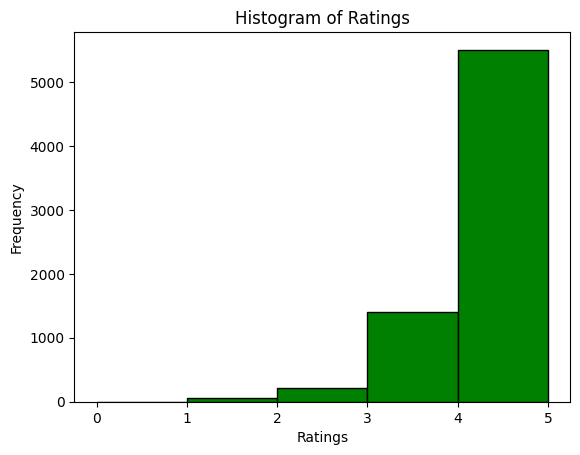

In [ ]:
# Import Packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Aggregate data
# Group by count of each Rating Value
df_grouped = df.groupBy("Rating").count()

# Convert to Pandas DataFrame
pandas_df = df_grouped.toPandas()

# We will specify the bins edges explicitly
bin_edges = [0, 1, 2, 3, 4, 5]

# Create the histogram
plt.hist(pandas_df['Rating'], weights=pandas_df['count'], bins=bin_edges, color='green', edgecolor='black')

# Set x-ticks to be the center of each bin
plt.xticks(np.arange(0, 6, 1), ['0', '1', '2', '3', '4','5'])

# Add titles and labels
plt.title('Histogram of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

# Show plot
plt.show()

*As you can see, most of the ratings of these apps are of very high quality. There is an extremely small amount of ratings that are below a 3*

**Reviews**

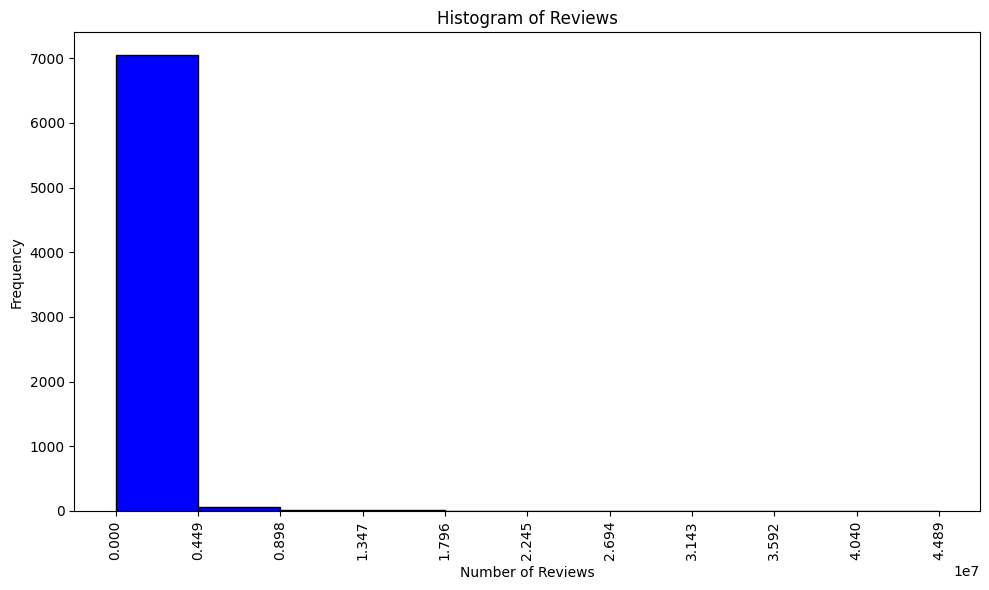

In [ ]:
# Group by "Reviews" and count each group
df_grouped_2 = df.groupBy("Reviews").count()

# Convert the grouped data to a Pandas DataFrame
reviews_pandas_df = df_grouped_2.toPandas()

# Use the 'Reviews' column to define bins if they are numeric and have a wide range
# Determine bin edges for 10 equal-width bins based on the min and max values
min_reviews = reviews_pandas_df['Reviews'].min()
max_reviews = reviews_pandas_df['Reviews'].max()
bins = np.linspace(min_reviews, max_reviews, num=11)  # 10 bins need 11 edges

# Create the histogram
plt.figure(figsize=(10, 6))
# Using 'count' column from grouped DataFrame as weights for the histogram
plt.hist(reviews_pandas_df['Reviews'], weights=reviews_pandas_df['count'], bins=bins, color='blue', edgecolor='black')

# Setting up x-ticks - it might be necessary to format ticks if they are large numbers
plt.xticks(bins, rotation='vertical')

# Add titles and labels
plt.title('Histogram of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of x-tick labels
plt.show()


*Most apps have about between 0 and 1,870,000 reviews*

**Size**

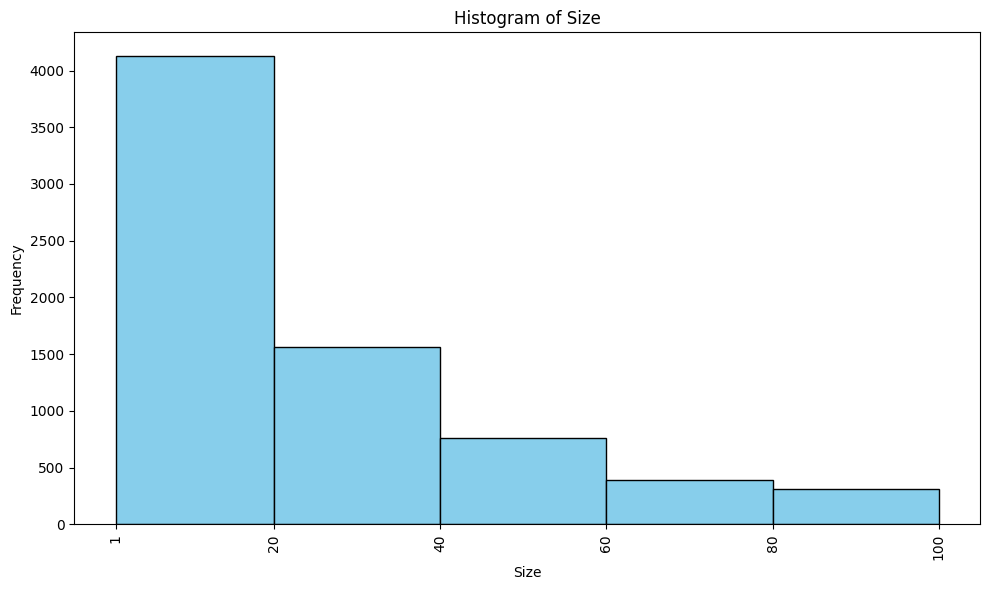

In [ ]:
# Group by "Size" and count each group
df_grouped_3 = df.groupBy("Size").count()

# Convert the grouped data to a Pandas DataFrame
size_pandas_df = df_grouped_3.toPandas()

# Define the bins for the "Size" histogram
bin_edges = [1, 20, 40, 60, 80, 100]  # Adjust your bins based on your specific range and preference

# Create the histogram for "Size"
plt.figure(figsize=(10, 6))  # Optional: defines the figure size
plt.hist(size_pandas_df['Size'], weights=size_pandas_df['count'], bins=bin_edges, color='skyblue', edgecolor='black')

# Set the titles and labels
plt.title('Histogram of Size')
plt.xlabel('Size')
plt.ylabel('Frequency')

# Define x-ticks to match bin edges and rotate them vertically
plt.xticks(bin_edges, rotation='vertical')

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()


*Most apps are about 1-20 MB*

**Price**

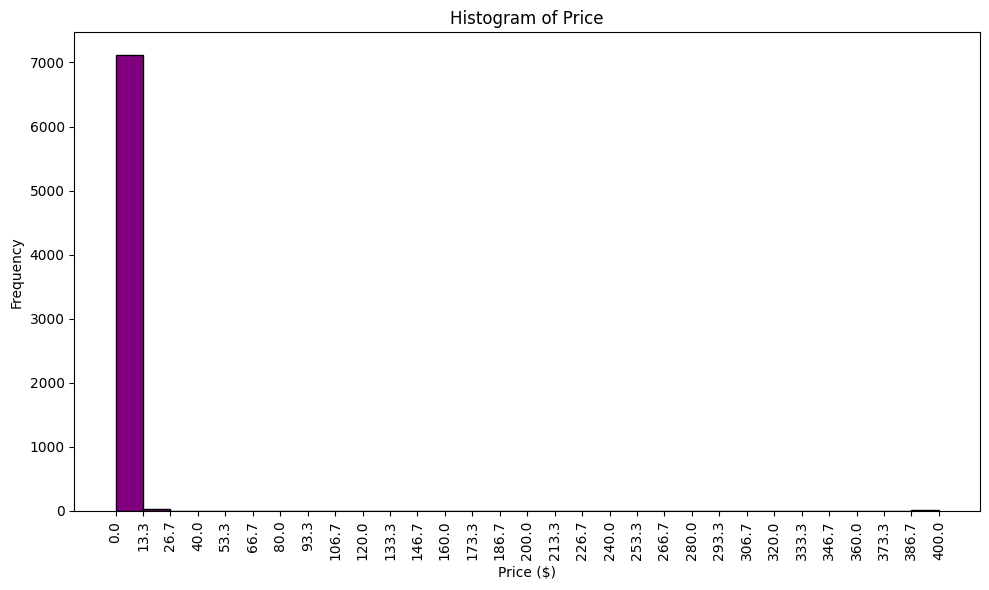

In [ ]:
# Group by "Price" and count each group
df_grouped_price = df.groupBy("Price").count()

# Convert the grouped data to a Pandas DataFrame
price_pandas_df = df_grouped_price.toPandas()

# Use the 'Price' column to define bins if they are numeric
# Determine bin edges for 30 equal-width bins based on the min and max values
min_price = price_pandas_df['Price'].min()
max_price = price_pandas_df['Price'].max()
bin_edges = np.linspace(min_price, max_price, num=31)  # 30 bins need 31 edges

# Create the histogram
plt.figure(figsize=(10, 6))
# Using 'count' column from grouped DataFrame as weights for the histogram
plt.hist(price_pandas_df['Price'], weights=price_pandas_df['count'], bins=bin_edges, color='purple', edgecolor='black')

# Setting up x-ticks - it might be necessary to format ticks if they are large numbers
plt.xticks(bin_edges, rotation='vertical')

# Add titles and labels
plt.title('Histogram of Price')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of x-tick labels
plt.show()

*The price for most apps are between 0 and 13 dollars*

**Installs**

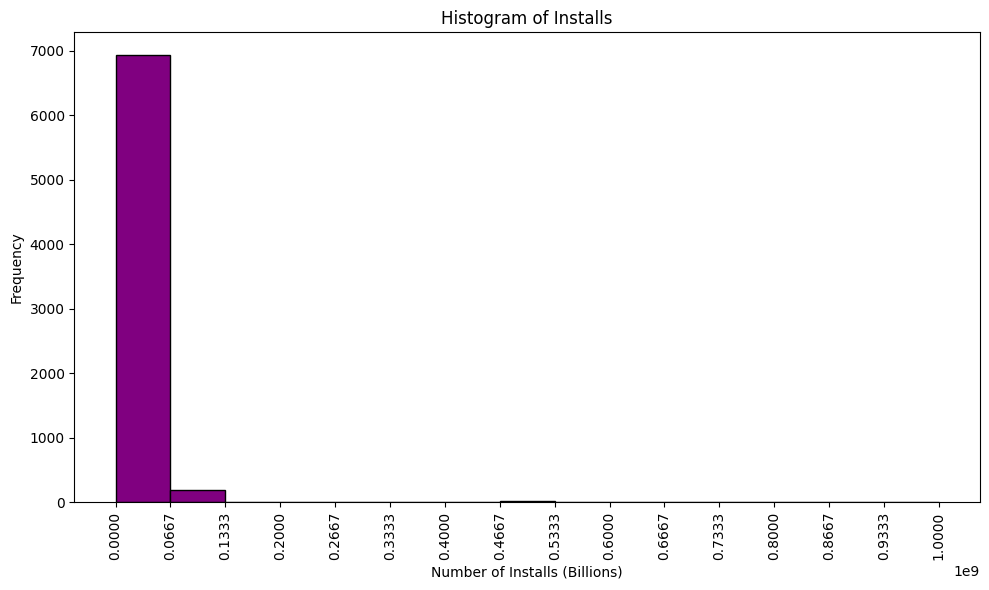

In [ ]:
# Group by "Installs" and count each group
df_grouped_installs = df.groupBy("Installs").count()

# Convert the grouped data to a Pandas DataFrame
installs_pandas_df = df_grouped_installs.toPandas()

# Use the 'Price' column to define bins if they are numeric
# Determine bin edges for 15 equal-width bins based on the min and max values
min_installs = installs_pandas_df['Installs'].min()
max_installs = installs_pandas_df['Installs'].max()
bin_edges = np.linspace(min_installs, max_installs, num=16)  # 15 bins need 16 edges

# Create the histogram
plt.figure(figsize=(10, 6))
# Using 'count' column from grouped DataFrame as weights for the histogram
plt.hist(installs_pandas_df['Installs'], weights=installs_pandas_df['count'], bins=bin_edges, color='purple', edgecolor='black')

# Setting up x-ticks - it might be necessary to format ticks if they are large numbers
plt.xticks(bin_edges, rotation='vertical')

# Add titles and labels
plt.title('Histogram of Installs')
plt.xlabel('Number of Installs (Billions)')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of x-tick labels
plt.show()


*Most apps have between 0 and 66.7 million installations*

---
### Scatterplots

Based on the correlation test I ran earlier, there are weak relationships between all of the numerical columns. I will still visuallt represent some of these relationships

In [ ]:
# Convert the DataFrame to Pandas for visualization
pandas_df = df.toPandas()

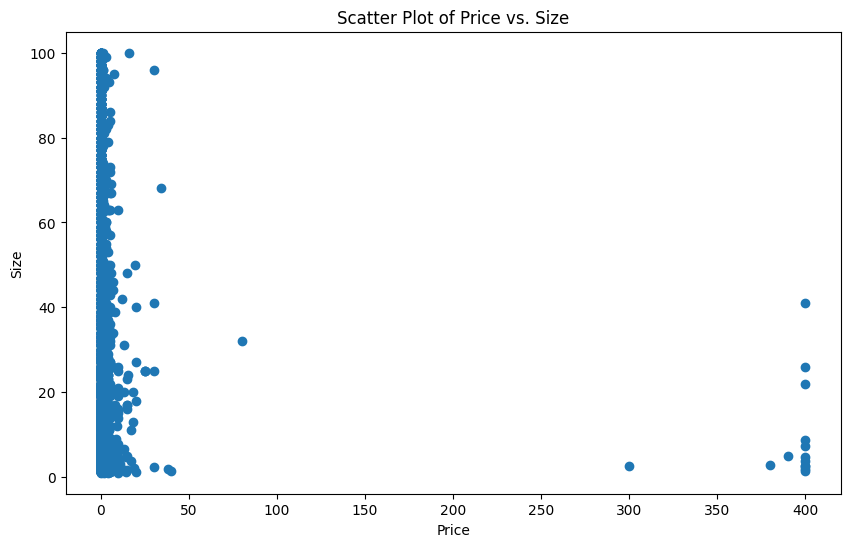

In [ ]:
# Scatter plot for Price and Size
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Price'], pandas_df['Size'])
plt.title('Scatter Plot of Price vs. Size')
plt.xlabel('Price')
plt.ylabel('Size')
plt.show()

*No clear relationship between price and size. The scatterplot also looks uneven due to the clear outliers, thus, a large amount of the points are clustered on the left side of the plot.

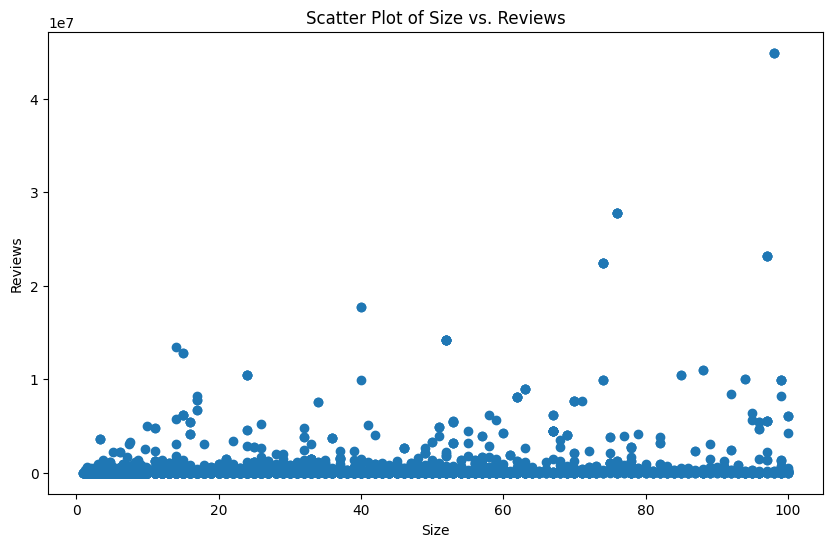

In [ ]:
# Scatter plot for Size and Reviews
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Size'], pandas_df['Reviews'])
plt.title('Scatter Plot of Size vs. Reviews')
plt.xlabel('Size')
plt.ylabel('Reviews')
plt.show()

No clear relationship between size and reviews. Also, there are a lot of outliers which makes most of the points clusterd at the bottom.

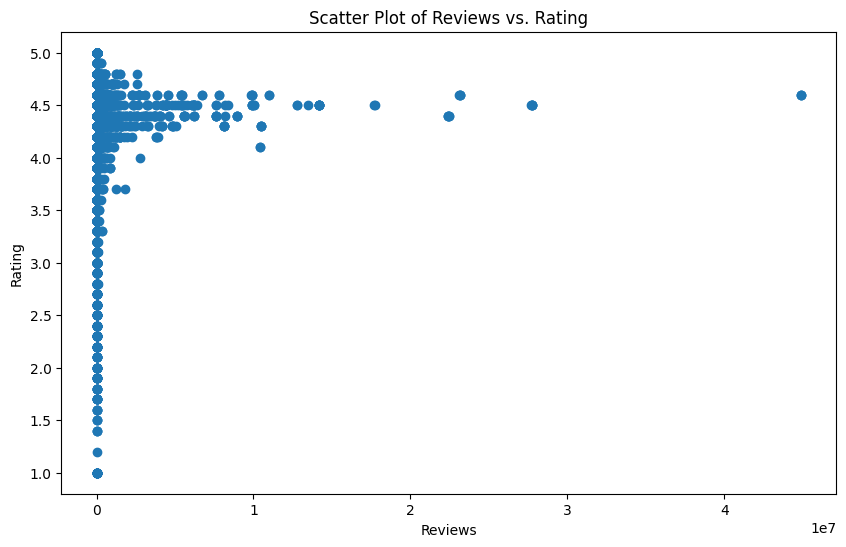

In [ ]:
# Scatter plot for Reviews and Rating
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Reviews'], pandas_df['Rating'])
plt.title('Scatter Plot of Reviews vs. Rating')
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.show()

*No clear relationship between reviews and ratning, the higher the rating, the lower the review, however, the outliers ruin any comprehensive interpretation.*

## Bar Charts for Categorical Variables

Category

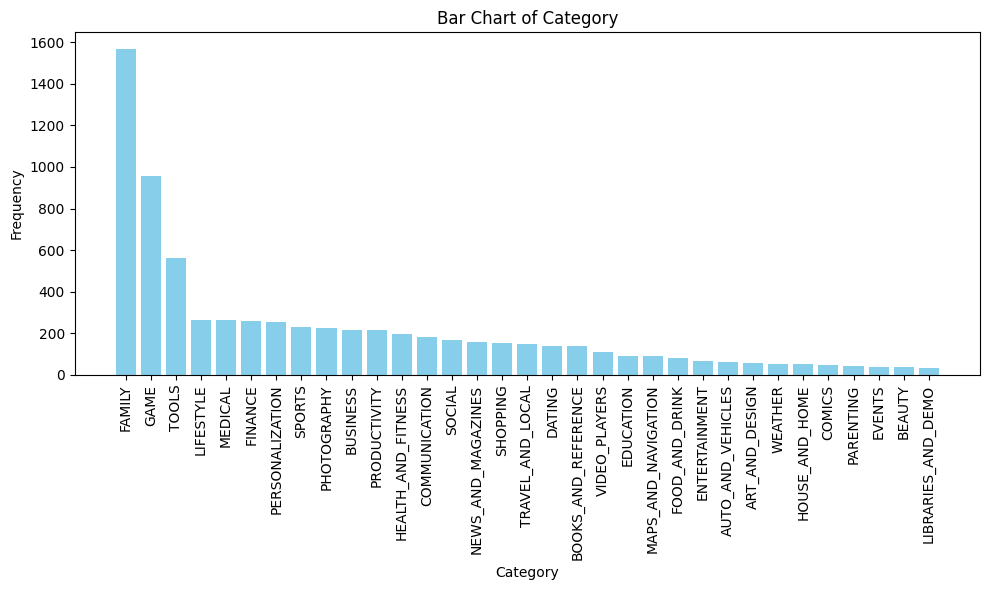

In [ ]:
# Aggregate data by 'Category' and order by the count
df_grouped_category = df.groupBy("Category").count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame
category_pandas_df = df_grouped_category.toPandas()

# Create the bar chart for 'Category'
plt.figure(figsize=(10, 6))
plt.bar(category_pandas_df['Category'], category_pandas_df['count'], color='skyblue')

# Set titles and labels
plt.title('Bar Chart of Category')
plt.xlabel('Category')
plt.ylabel('Frequency')

# Optionally rotate the x-ticks for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

The 'Family' category has the highest frequency, indicating it has the most apps available compared to the other categories listed.
The 'Game' category is the second most frequent, suggesting it's also a popular category for apps.
Categories such as 'Tools', 'Lifestyle', and 'Medical' follow next, with a substantial number of apps but significantly fewer than 'Family' and 'Game'.
The remaining categories show a decreasing frequency of apps available, with 'Libraries and Demo' and 'Beauty' having the least frequency among the displayed categories.
Categories related to utilities and personal use (like 'Family', 'Game', 'Tools') have more apps, while niche categories (like 'Weather', 'Events', 'Beauty') have fewer apps available.

Content Rating

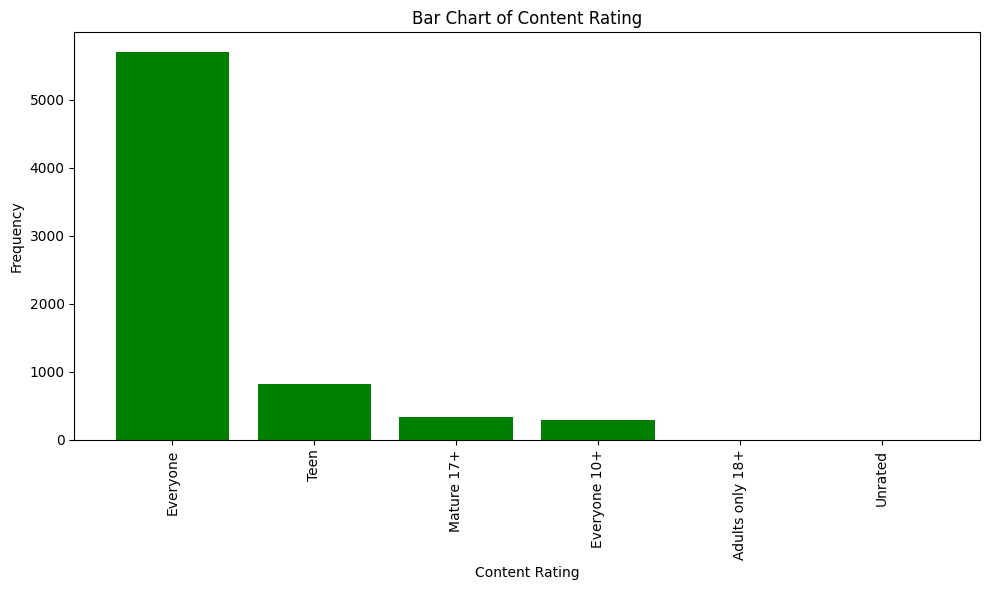

In [ ]:
# Aggregate data by 'Content Rating' and order by the count
df_grouped_content_rating = df.groupBy('Content Rating').count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame
content_rating_pandas_df = df_grouped_content_rating.toPandas()

# Create the bar chart for 'Category'
plt.figure(figsize=(10, 6))
plt.bar(content_rating_pandas_df['Content Rating'], content_rating_pandas_df['count'], color='green')

# Set titles and labels
plt.title('Bar Chart of Content Rating')
plt.xlabel('Content Rating')
plt.ylabel('Frequency')

# Optionally rotate the x-ticks for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

A vast majority of apps are rated as appropriate for 'Everyone', making it the most common content rating by a significant margin.
The 'Teen' rating is the second most common, but substantially less frequent than the 'Everyone' category.
'Mature 17+' and 'Everyone 10+' categories follow, with even fewer apps falling into these content rating categories.
There are very few apps rated as 'Adults only 18+' and a small number of 'Unrated' apps.
The distribution suggests that app developers tend to target a general audience, including children and adults, to reach the widest possible user base.
The relatively small number of apps with higher age ratings might reflect either a lower production rate of such apps or stricter publishing policies on platforms regarding adult content.

Android Ver

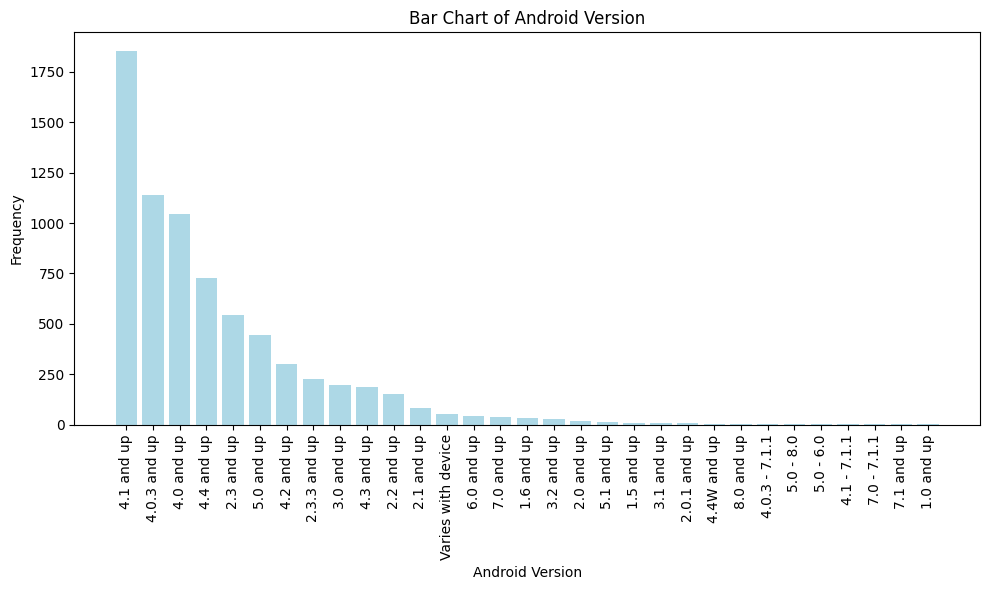

In [ ]:
# Aggregate data by 'AndroidVer' and order by the count
df_grouped_android_ver = df.groupBy("Android Ver").count().orderBy("count", ascending=False)

# Convert to Pandas DataFrame
android_ver_pandas_df = df_grouped_android_ver.toPandas()

# Create the bar chart for 'Android Ver'
plt.figure(figsize=(10, 6))
plt.bar(android_ver_pandas_df['Android Ver'], android_ver_pandas_df['count'], color='lightblue')

# Set titles and labels
plt.title('Bar Chart of Android Version')
plt.xlabel('Android Version')
plt.ylabel('Frequency')

# Optionally rotate the x-ticks for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()


A majority of apps that are in the datasey only require older Android Versions. For context, the newest Android version is 13 today.

---
## Outlier Analysis (using z-score)

**Rating**

In [ ]:
from pyspark.sql.functions import abs as abs_spark

# Calculate mean and standard deviation of ratings
mean_rating = df.agg({"Rating": "mean"}).collect()[0][0]
std_dev_rating = df.agg({"Rating": "stddev"}).collect()[0][0]

# Calculate z-scores for each rating
z_scores_df = df.withColumn("Z_Score", (df["Rating"] - mean_rating) / std_dev_rating)

# Define threshold (e.g., 3 standard deviations)
threshold = 3

# Identify outliers
outliers_df_rating = z_scores_df.filter(abs_spark(z_scores_df["Z_Score"]) > threshold)

# Show amount of outliers
outliers_df_rating.count()


139

There are 139 outliers.

In [ ]:
# Show how many rows there are in the current dataframe
df.count()

7160

In [ ]:
z = (139/7162)*100
print(str(z) + "%"  + " rows will be removed")

1.9407986595922928% rows will be removed


In [ ]:
# Filter out the outliers from the original DataFrame
df = df.join(outliers_df_rating, on=df.columns, how='left_anti')

# Show the number of rows in the new filtered DataFrame
df.count()

7021

In [ ]:
# Calculate the minimum value of the column
min_value = df.selectExpr("min(Rating)").collect()[0][0]

# Calculate the maximum value of the column
max_value = df.selectExpr("max(Rating)").collect()[0][0]

# Print the results
print("Minimum value:", min_value)
print("Maximum value:", max_value)
print("As you can see, the minimum value rose from 0 to 2.5")

Minimum value: 2.5999999046325684
Maximum value: 5.0
As you can see, the minimum value rose from 0 to 2.5


**Reviews**

In [ ]:
# Calculate mean and standard deviation of reviews
mean_reviews = df.agg({"Reviews": "mean"}).collect()[0][0]
std_dev_reviews = df.agg({"Reviews": "stddev"}).collect()[0][0]

# Calculate z-scores for each review count
z_scores_df = df.withColumn("Z_Score", (df["Reviews"] - mean_reviews) / std_dev_reviews)

# Define threshold (e.g., 3 standard deviations)
threshold = 3

# Identify outliers
outliers_df_reviews = z_scores_df.filter(abs_spark(z_scores_df["Z_Score"]) > threshold)

# Show amount of outliers
outliers_df_reviews.count()


83

There are 83 outliers

In [ ]:
# Show how many rows there are in the current dataframe
df.count()

7021

In [ ]:
z = (83/7023)*100
print(str(z) + "%"  + " rows will be removed")

1.1818311262993022% rows will be removed


In [ ]:
# Filter out the outliers from the original DataFrame
df = df.join(outliers_df_reviews, on=df.columns, how='left_anti')

# Show the number of rows in the new filtered DataFrame
df.count()

6938

In [ ]:
# Calculate the minimum value of the column
min_value = df.selectExpr("min(Reviews)").collect()[0][0]

# Calculate the maximum value of the column
max_value = df.selectExpr("max(Reviews)").collect()[0][0]

# Print the results
print("Minimum value:", min_value)
print("Maximum value:", max_value)
print("As you can see, the max value fell from 4.8 billion to 4,830,407")

Minimum value: 1.0
Maximum value: 5637451.0
As you can see, the max value fell from 4.8 billion to 4,830,407


**Size**

In [ ]:
# Calculate mean and standard deviation of sizes
mean_size = df.agg({"Size": "mean"}).collect()[0][0]
std_dev_size = df.agg({"Size": "stddev"}).collect()[0][0]

# Calculate z-scores for each size
z_scores_df = df.withColumn("Z_Score", (df["Size"] - mean_size) / std_dev_size)

# Define threshold (e.g., 3 standard deviations)
threshold = 3

# Identify outliers
outliers_df_size = z_scores_df.filter(abs_spark(z_scores_df["Z_Score"]) > threshold)

# Show amount of outliers
outliers_df_size.count()


136

There are 136 outliers

In [ ]:
z = (136/6940)*100
print(str(z) + "%"  + " rows will be removed")

1.9596541786743515% rows will be removed


In [ ]:
# Filter out the outliers from the original DataFrame
df = df.join(outliers_df_size, on=df.columns, how='left_anti')

# Show the number of rows in the new filtered DataFrame
df.count()

6802

In [ ]:
# Calculate the minimum value of the column
min_value = df.selectExpr("min(Size)").collect()[0][0]

# Calculate the maximum value of the column
max_value = df.selectExpr("max(Size)").collect()[0][0]

# Print the results
print("Minimum value:", min_value)
print("Maximum value:", max_value)
print("As you can see, the max value fell from 100 to 92")

Minimum value: 1.0
Maximum value: 92.0
As you can see, the max value fell from 100 to 92


**Price**

In [ ]:
# Calculate mean and standard deviation of prices
mean_price = df.agg({"Price": "mean"}).collect()[0][0]
std_dev_price = df.agg({"Price": "stddev"}).collect()[0][0]

# Calculate z-scores for each price
z_scores_df = df.withColumn("Z_Score", (df["Price"] - mean_price) / std_dev_price)

# Define threshold (e.g., 3 standard deviations)
threshold = 3

# Identify outliers
outliers_df_price = z_scores_df.filter(abs_spark(z_scores_df["Z_Score"]) > threshold)

# Show amount of outliers
outliers_df_price.count()


15

There are 15 outliers

In [ ]:
z = (15/6804)*100
print(str(z) + "%"  + " rows will be removed")

0.2204585537918871% rows will be removed


In [ ]:
# Filter out the outliers from the original DataFrame
df = df.join(outliers_df_price, on=df.columns, how='left_anti')

# Show the number of rows in the new filtered DataFrame
df.count()

6787

In [ ]:
# Calculate the minimum value of the column
min_value = df.selectExpr("min(Price)").collect()[0][0]

# Calculate the maximum value of the column
max_value = df.selectExpr("max(Price)").collect()[0][0]

# Print the results
print("Minimum value:", min_value)
print("Maximum value:", max_value)
print("As you can see, the max value fell from 400 to 39.99")

Minimum value: 0.0
Maximum value: 39.9900016784668
As you can see, the max value fell from 400 to 39.99


**Installs**

In [ ]:
# Calculate mean and standard deviation of installs
mean_installs = df.agg({"Installs": "mean"}).collect()[0][0]
std_dev_installs = df.agg({"Installs": "stddev"}).collect()[0][0]

# Calculate z-scores for each install count
z_scores_df = df.withColumn("Z_Score", (df["Installs"] - mean_installs) / std_dev_installs)

# Define threshold (e.g., 3 standard deviations)
threshold = 3

# Identify outliers
outliers_df_installs = z_scores_df.filter(abs_spark(z_scores_df["Z_Score"]) > threshold)

# Show amount of outliers
outliers_df_installs.count()

132

There are 132 outliers

In [ ]:
z = (132/6789)*100
print(str(z) + "%"  + " rows will be removed")

1.9443216968625716% rows will be removed


In [ ]:
# Filter out the outliers from the original DataFrame
df = df.join(outliers_df_installs, on=df.columns, how='left_anti')

# Show the number of rows in the new filtered DataFrame
df.count()

6655

In [ ]:
# Calculate the minimum value of the column
min_value = df.selectExpr("min(Installs)").collect()[0][0]

# Calculate the maximum value of the column
max_value = df.selectExpr("max(Installs)").collect()[0][0]

# Print the results
print("Minimum value:", min_value)
print("Maximum value:", max_value)
print("As you can see, the max value fell from 1 billion to 50,000,000")

Minimum value: 1
Maximum value: 50000000
As you can see, the max value fell from 1 billion to 50,000,000


In [ ]:
# Show new df with no outliers
df.show()

+------------------+------+--------+----+--------+----+-----+--------------+------------+
|          Category|Rating| Reviews|Size|Installs|Type|Price|Content Rating| Android Ver|
+------------------+------+--------+----+--------+----+-----+--------------+------------+
|            DATING|   3.9|  8723.0|13.0|  500000|Free|  0.0|    Mature 17+|  4.1 and up|
|     ENTERTAINMENT|   4.3|   303.0|44.0|   10000|Free|  0.0|          Teen|  4.2 and up|
|    FOOD_AND_DRINK|   4.0| 43614.0|25.0| 1000000|Free|  0.0|      Everyone|4.0.3 and up|
|LIBRARIES_AND_DEMO|   4.5|  1703.0|22.0|  100000|Free|  0.0|      Everyone|4.0.3 and up|
|              GAME|   4.2| 46416.0|73.0|10000000|Free|  0.0|      Everyone|  4.1 and up|
|              GAME|   4.6|280098.0|50.0|10000000|Free|  0.0|      Everyone|4.0.3 and up|
|            FAMILY|   4.4|    38.0|16.0|     100|Paid| 0.99|      Everyone|  4.0 and up|
|           MEDICAL|   4.6|   129.0| 2.9|   10000|Paid| 5.49|      Everyone|  4.1 and up|
|         

---
# Rerun Descriptive Statistics

**Rating**

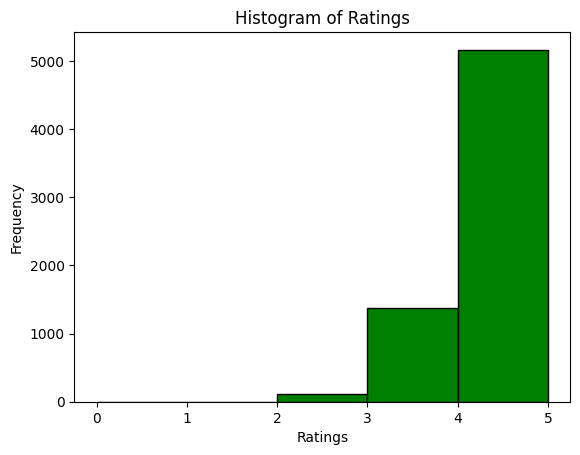

In [ ]:
# Aggregate data
# Group by count of each Rating Value
df_grouped = df.groupBy("Rating").count()

# Convert to Pandas DataFrame
pandas_df = df_grouped.toPandas()

# We will specify the bins edges explicitly
bin_edges = [0, 1, 2, 3, 4, 5]

# Create the histogram
plt.hist(pandas_df['Rating'], weights=pandas_df['count'], bins=bin_edges, color='green', edgecolor='black')

# Set x-ticks to be the center of each bin
plt.xticks(np.arange(0, 6, 1), ['0', '1', '2', '3', '4','5'])

# Add titles and labels
plt.title('Histogram of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

# Show plot
plt.show()

*As you can see, the lower outliers are filtered out. Distribution is extremely similar, still.

**Reviews**

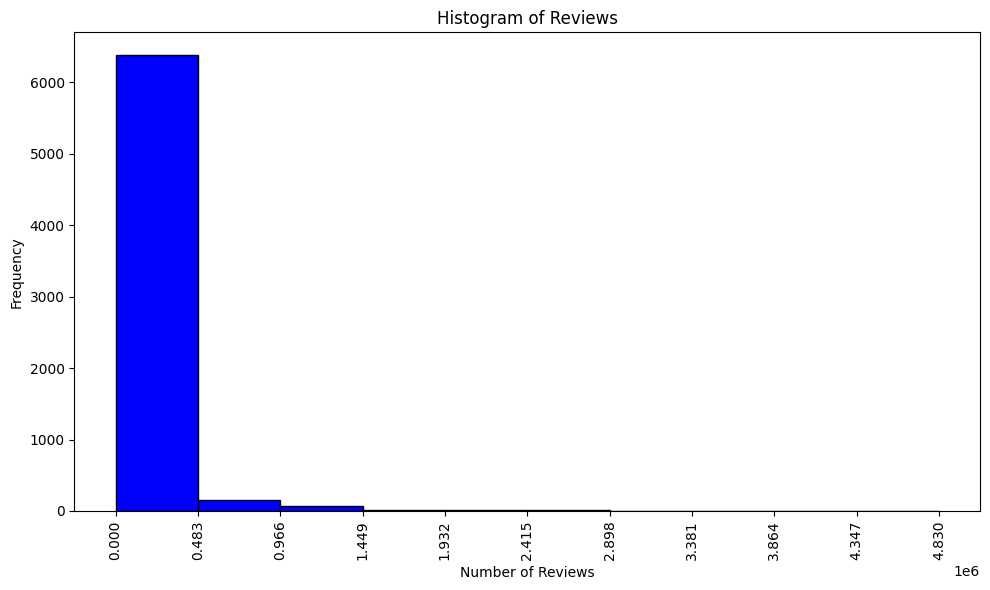

In [ ]:
# Group by "Reviews" and count each group
df_grouped_2 = df.groupBy("Reviews").count()

# Convert the grouped data to a Pandas DataFrame
reviews_pandas_df = df_grouped_2.toPandas()

# Use the 'Reviews' column to define bins if they are numeric and have a wide range
# Determine bin edges for 10 equal-width bins based on the min and max values
min_reviews = reviews_pandas_df['Reviews'].min()
max_reviews = reviews_pandas_df['Reviews'].max()
bins = np.linspace(min_reviews, max_reviews, num=11)  # 10 bins need 11 edges

# Create the histogram
plt.figure(figsize=(10, 6))
# Using 'count' column from grouped DataFrame as weights for the histogram
plt.hist(reviews_pandas_df['Reviews'], weights=reviews_pandas_df['count'], bins=bins, color='blue', edgecolor='black')

# Setting up x-ticks - it might be necessary to format ticks if they are large numbers
plt.xticks(bins, rotation='vertical')

# Add titles and labels
plt.title('Histogram of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of x-tick labels
plt.show()


Distribution for Reviews if also very similar to the original distribution. Extremely large values on the right of the chart is at 0, starting at the 7th bins. The max value is significantly lower than original.

**Size**

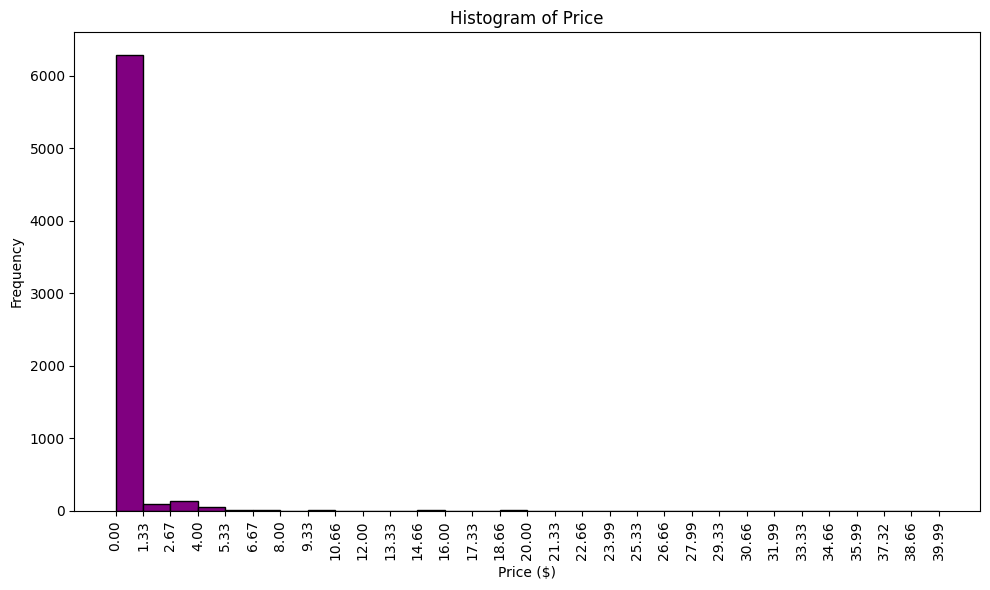

In [ ]:
# Group by "Price" and count each group
df_grouped_price = df.groupBy("Price").count()

# Convert the grouped data to a Pandas DataFrame
price_pandas_df = df_grouped_price.toPandas()

# Use the 'Price' column to define bins if they are numeric
# Determine bin edges for 30 equal-width bins based on the min and max values
min_price = price_pandas_df['Price'].min()
max_price = price_pandas_df['Price'].max()
bin_edges = np.linspace(min_price, max_price, num=31)  # 30 bins need 31 edges

# Create the histogram
plt.figure(figsize=(10, 6))
# Using 'count' column from grouped DataFrame as weights for the histogram
plt.hist(price_pandas_df['Price'], weights=price_pandas_df['count'], bins=bin_edges, color='purple', edgecolor='black')

# Setting up x-ticks - it might be necessary to format ticks if they are large numbers
plt.xticks(bin_edges, rotation='vertical')

# Add titles and labels
plt.title('Histogram of Price')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of x-tick labels
plt.show()

The extremely large values are no longer existent in the cart and the max bin is lower (from 500 to 39.99).

**Size**

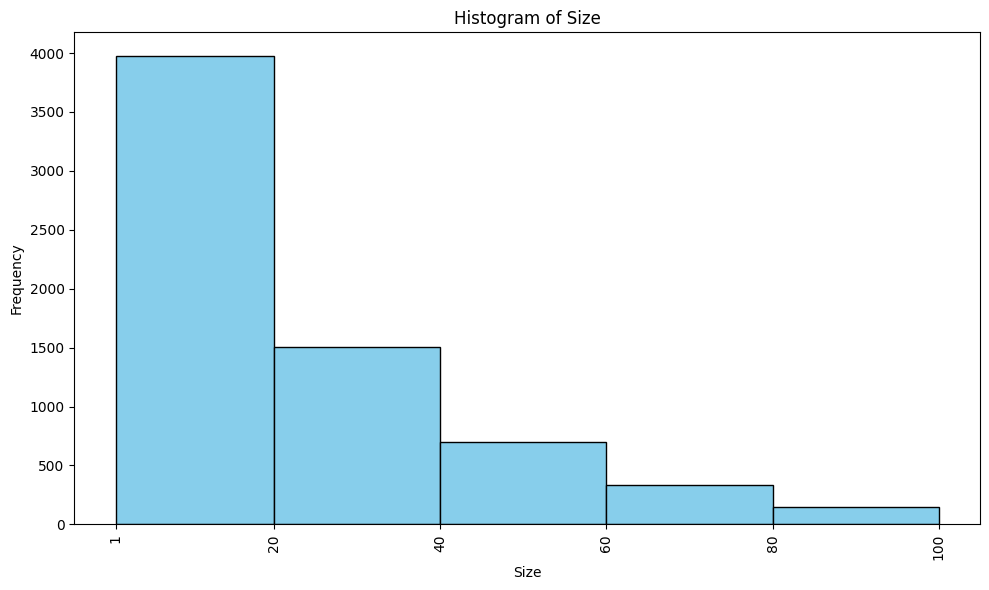

In [ ]:
# Group by "Size" and count each group
df_grouped_3 = df.groupBy("Size").count()

# Convert the grouped data to a Pandas DataFrame
size_pandas_df = df_grouped_3.toPandas()

# Define the bins for the "Size" histogram
bin_edges = [1, 20, 40, 60, 80, 100]  # Adjust your bins based on your specific range and preference

# Create the histogram for "Size"
plt.figure(figsize=(10, 6))  # Optional: defines the figure size
plt.hist(size_pandas_df['Size'], weights=size_pandas_df['count'], bins=bin_edges, color='skyblue', edgecolor='black')

# Set the titles and labels
plt.title('Histogram of Size')
plt.xlabel('Size')
plt.ylabel('Frequency')

# Define x-ticks to match bin edges and rotate them vertically
plt.xticks(bin_edges, rotation='vertical')

# Show the plot
plt.tight_layout()  # Adjust the layout
plt.show()

Distribution is almost exactly the same. 80-100 bin is slightly smaller.

**Installs**

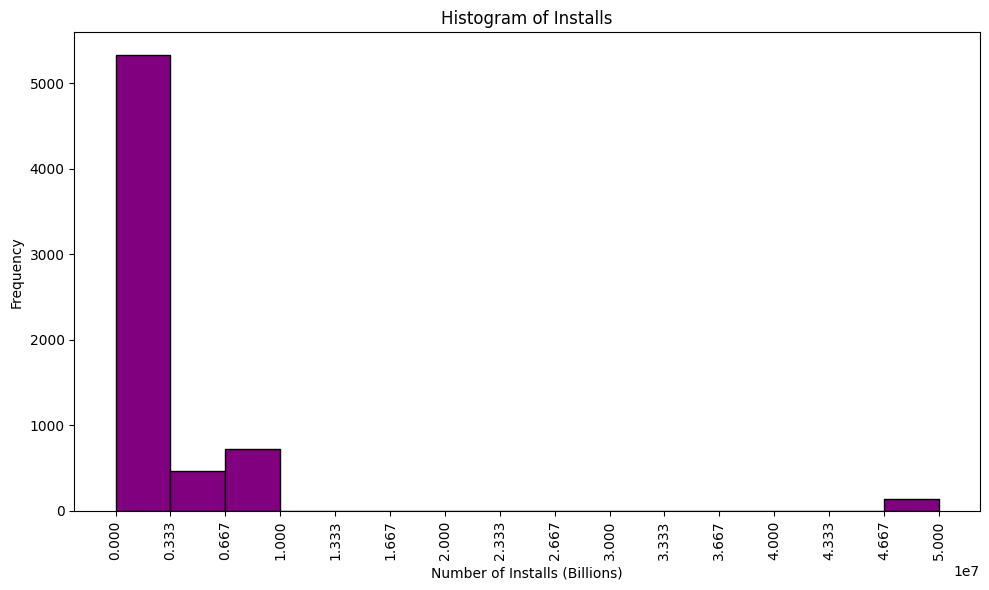

In [ ]:
# Group by "Installs" and count each group
df_grouped_installs = df.groupBy("Installs").count()

# Convert the grouped data to a Pandas DataFrame
installs_pandas_df = df_grouped_installs.toPandas()

# Use the 'Price' column to define bins if they are numeric
# Determine bin edges for 15 equal-width bins based on the min and max values
min_installs = installs_pandas_df['Installs'].min()
max_installs = installs_pandas_df['Installs'].max()
bin_edges = np.linspace(min_installs, max_installs, num=16)  # 15 bins need 16 edges

# Create the histogram
plt.figure(figsize=(10, 6))
# Using 'count' column from grouped DataFrame as weights for the histogram
plt.hist(installs_pandas_df['Installs'], weights=installs_pandas_df['count'], bins=bin_edges, color='purple', edgecolor='black')

# Setting up x-ticks - it might be necessary to format ticks if they are large numbers
plt.xticks(bin_edges, rotation='vertical')

# Add titles and labels
plt.title('Histogram of Installs')
plt.xlabel('Number of Installs (Billions)')
plt.ylabel('Frequency')

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping of x-tick labels
plt.show()


Distribution has a much lower max value.

## Scatterplots

In [ ]:
# Convert the DataFrame to Pandas for visualization
pandas_df = df.toPandas()

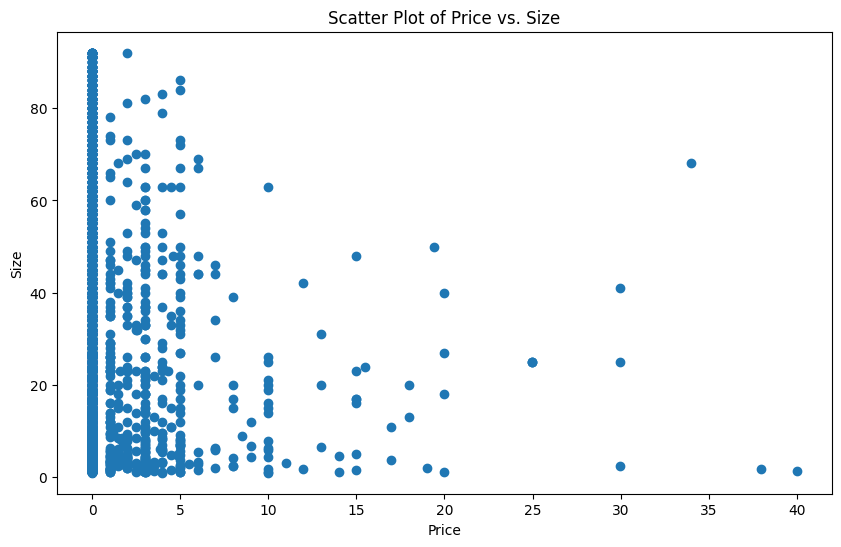

In [ ]:
# Scatter plot for Price and Size
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Price'], pandas_df['Size'])
plt.title('Scatter Plot of Price vs. Size')
plt.xlabel('Price')
plt.ylabel('Size')
plt.show()

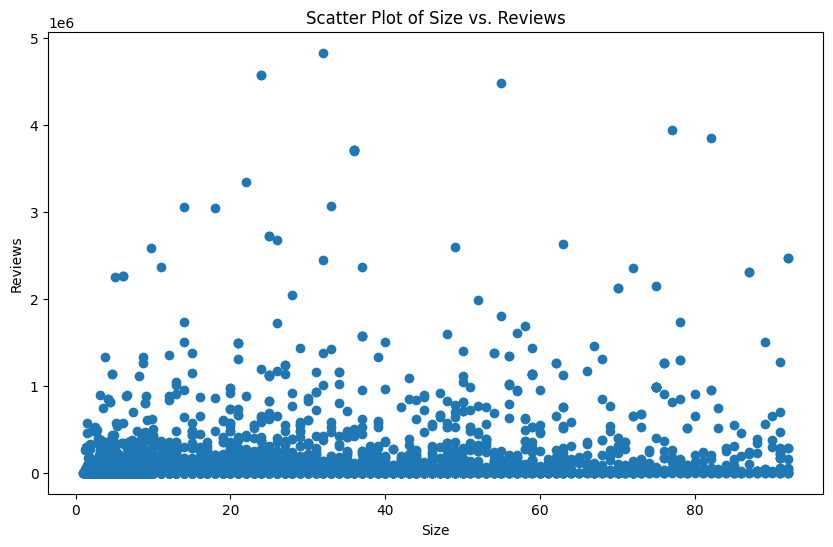

In [ ]:
# Scatter plot for Size and Reviews
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Size'], pandas_df['Reviews'])
plt.title('Scatter Plot of Size vs. Reviews')
plt.xlabel('Size')
plt.ylabel('Reviews')
plt.show()

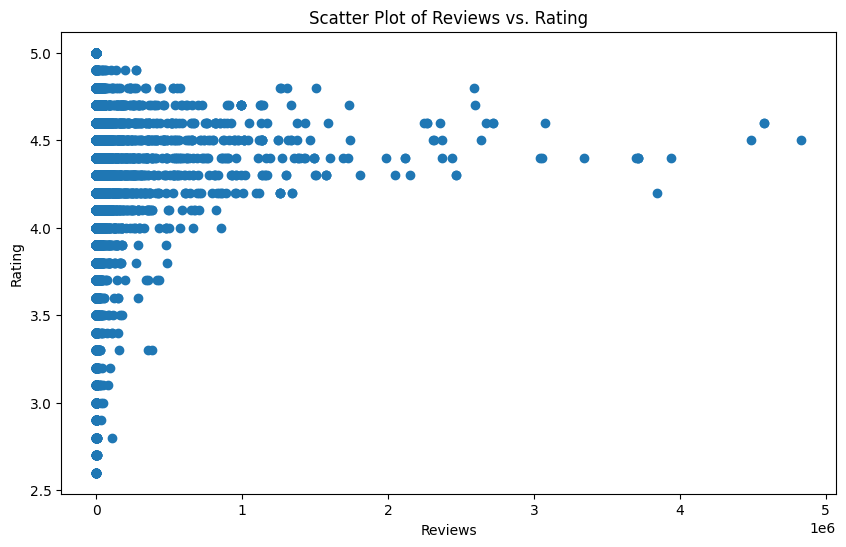

In [ ]:
# Scatter plot for Reviews and Rating
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['Reviews'], pandas_df['Rating'])
plt.title('Scatter Plot of Reviews vs. Rating')
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.show()

Lack of correlation between these numerical variables

Save cleaned csv file

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the file path on your Google Drive
file_path = "/content/drive/My Drive/cleaned_playstore_data.csv"

# Save the DataFrame as a CSV file
df.write.csv(file_path, header=True)

Mounted at /content/drive
